In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from files
def load_data():
    XAC_1 = np.loadtxt('XAC_1.txt')
    XAC_2 = np.loadtxt('XAC_2.txt')
    XBC_1 = np.loadtxt('XBC_1.txt')
    XBC_2 = np.loadtxt('XBC_2.txt')
    stimuli1 = np.load('stimuli1.npy', allow_pickle=True).item()
    stimuli2 = np.load('stimuli2.npy', allow_pickle=True).item()
    return XAC_1, XAC_2, XBC_1, XBC_2, stimuli1, stimuli2

# Input-output function
def in_out(I1, I2, X, W, sig, st):
    in1 = 1 / np.exp(((I1 - X[st, 0]) / sig)**2) # Change this, Sim for s1 ****
    in2 = 1 / np.exp(((I2 - X[st, 1]) / sig)**2) # Change this, Sim for s2 ****
    In = np.kron(in1, in2) # Grid of input activtions *********
    In = (In / np.sum(In)).reshape(-1, 1) # *****
    
    
    Out = W @ In
    return In, Out # Input -> Output Activations

# Exemplar function
def exemplar(alf, b, sig, XAC, XBC, P, nr, cutoff):
    ns = XAC.shape[0]
    Max = int(np.round(np.max(XAC)))
    I1 = np.arange(Max + 1)
    I2 = np.arange(Max + 1)
    W = np.zeros((2, (Max + 1)**2)) # Change this, weight matrix *****
    T = np.zeros((nr, 4))
    mT = np.zeros(nr)

    for rep in range(nr): # loop replication
        for st in range(ns): # loop for stimuli
            In, Out = in_out(I1, I2, XAC, W, sig, st)
            WA = alf * (np.array([[1], [0]]) - Out) @ In.T # delta rule
            W += WA

            In, Out = in_out(I1, I2, XBC, W, sig, st)
            WB = alf * (np.array([[0], [1]]) - Out) @ In.T
            W += WB

        for st in range(4):
            In, Out = in_out(I1, I2, P, W, sig, st)
            if st in [1, 2]:
                pa = np.exp(b * Out) / np.sum(np.exp(b * Out))
                T[rep, st] = pa[0, 0]
            else:
                pb = np.exp(b * Out) / np.sum(np.exp(b * Out))
                T[rep, st] = pb[0, 0]

        mT[rep] = ((T[rep, 1] - T[rep, 0]) > cutoff) & ((T[rep, 2] - T[rep, 3]) > cutoff)

    return mT, T

# Main program
def main():
    nr = 50  # (1) Sets number of repetitions for training
    
    # Load data
    XAC_1, XAC_2, XBC_1, XBC_2, stimuli1, stimuli2 = load_data()
    XAC = XAC_2  # Use stimuli 2
    XBC = XBC_2  # Use stimuli 2
    P = stimuli2['P']  # Ensure correct stimuli set is used

    # (3) Set learning rate values
    aa = 25
    AV = np.arange(1, aa + 1) / aa
    
    # (4) Choice consistency
    bb = 15
    BV = np.arange(1, bb + 1)
    
    # (5) Initializes test result matrix
    MT = np.zeros((aa, bb))
    
    # (6) Set choice consistency
    sig = 5
    cutoff = 0.2  # Used to test pattern
    
    # Learning curve for one parameter setting
    alf = 0.35
    b = 2.5
    Mt, Pc = prototype_1t(alf, b, sig, XAC, XBC, P, nr, cutoff)
    
    # (7) Loop through predictions
    for i in range(aa):
        for j in range(bb):
            alf = AV[i]
            b = BV[j]
            mT, _ = prototype_1t(alf, b, sig, XAC, XBC, P, nr, cutoff)
            MT[i, j] = mT[-1]  # (9) Store result
    
    # Plot learning curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, nr + 1), (Pc[:, 1] + Pc[:, 2]) / 2, '-.', linewidth=2)
    plt.xlabel('Learning trials')
    plt.ylabel('Probability correct')
    
    # (10) Plot results
    plt.subplot(1, 2, 2)
    plt.spy(MT)
    plt.xlabel('Proportion of correct patterns')
    
    # Compute final proportion of correct patterns
    pcp = np.sum(MT == 1) / (MT.shape[0] * MT.shape[1])
    print('Proportion of correct patterns:', pcp)
    
    plt.show()

if __name__ == "__main__":
    main()


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 144 is different from 24)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stimuli(XAC, XBC, XAR, XBR, P):
    plt.figure(figsize=(10, 5))

    # Categorization plot
    plt.subplot(1, 2, 1)
    plt.scatter(XAC[:, 0], XAC[:, 1], marker='+', label='A')
    plt.scatter(XBC[:, 0], XBC[:, 1], marker='o', label='B')
    plt.legend()
    plt.xlim(-2, 15)
    plt.ylim(-2, 15)
    plt.title('Categorization')
    plt.grid(True)  # Add grid

    # Generalization plot
    plt.subplot(1, 2, 2)
    plt.scatter(XAR[:, 0], XAR[:, 1], marker='+', label='A')
    plt.scatter(XBR[:, 0], XBR[:, 1], marker='o', label='B')
    plt.scatter(P[:, 0], P[:, 1], marker='x', color='k', label='P')
    plt.xlim(-2, 15)
    plt.ylim(-2, 15)
    plt.title('Generalization')
    plt.grid(True)  # Add grid

    plt.show()


[[ 1  1]
 [ 1 10]
 [10  1]
 [10 10]]


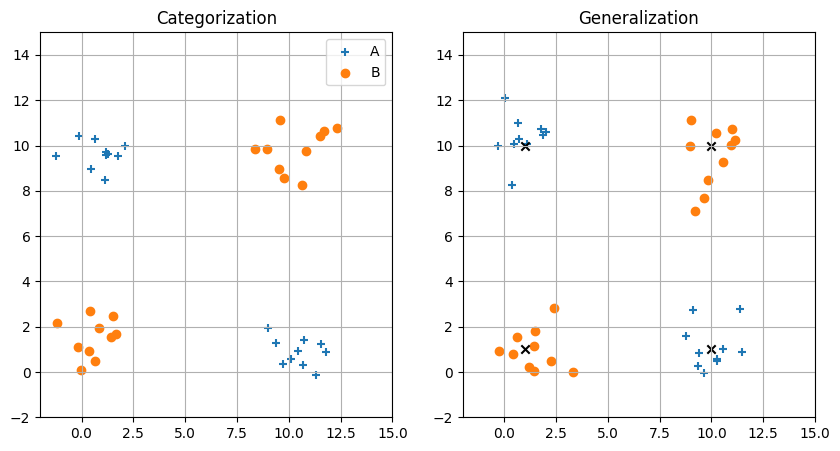

In [24]:
# Example of loading data and calling the function
stimuli = np.load('stimuli1.npy', allow_pickle=True).item()
XAC = stimuli['XAC'] # Training Cat A, width of nose
XBC = stimuli['XBC'] # Training Cat B, distance between nose & math
XAR = stimuli['XAR'] # Test Cat A
XBR = stimuli['XBR'] # Test Cat B
P = stimuli['P']

print(P)

plot_stimuli(XAC, XBC, XAR, XBR, P)

[[ 1  1]
 [ 2 10]
 [ 9  1]
 [10  9]]
20


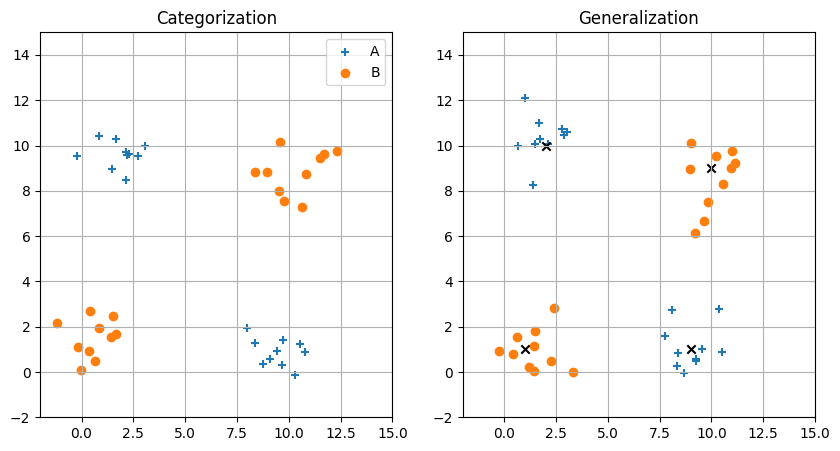

In [34]:
# Example of loading data and calling the function
stimuli = np.load('stimuli2.npy', allow_pickle=True).item()
XAC = stimuli['XAC']
XBC = stimuli['XBC']
XAR = stimuli['XAR']
XBR = stimuli['XBR']
P = stimuli['P']

print(P)

plot_stimuli(XAC, XBC, XAR, XBR, P)



In [66]:
# Extract and compare the matrix P from both stimuli sets

stimuli1 = np.load('stimuli1.npy', allow_pickle=True).item()
stimuli2 = np.load('stimuli2.npy', allow_pickle=True).item()

P1 = stimuli1["P"]
P2 = stimuli2["P"]

P1 = P1.astype(np.int16)
P2 = P2.astype(np.int16)

print(P1)
print(P2)

# Check the shape of P matrices
P_shape_identical = P1.shape == P2.shape

# Identify differences
P_difference = P1 - P2

# Display results
P_shape_identical, P_difference


[[ 1  1]
 [ 1 10]
 [10  1]
 [10 10]]
[[ 1  1]
 [ 2 10]
 [ 9  1]
 [10  9]]


(True,
 array([[ 0,  0],
        [-1,  0],
        [ 1,  0],
        [ 0,  1]], dtype=int16))

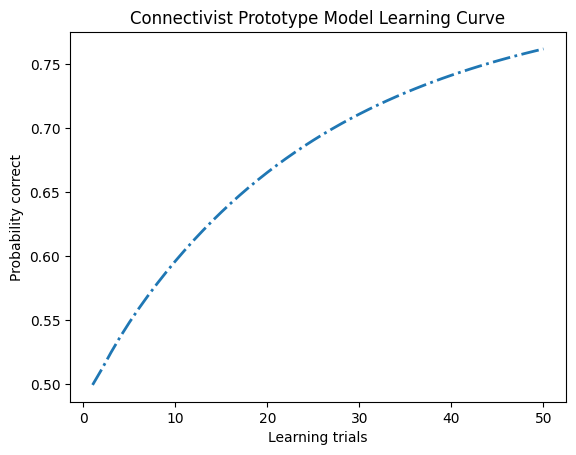

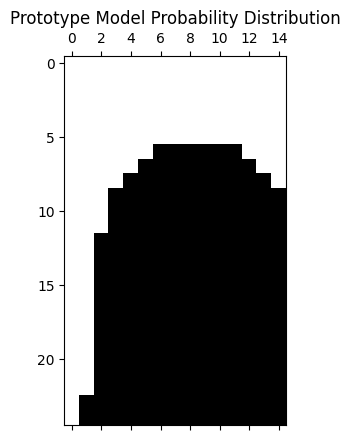

Proportion of correct patterns: 0.616


In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from files
def load_data():
    XAC_1 = np.loadtxt('XAC_1.txt')
    XAC_2 = np.loadtxt('XAC_2.txt')
    XBC_1 = np.loadtxt('XBC_1.txt')
    XBC_2 = np.loadtxt('XBC_2.txt')
    stimuli1 = np.load('stimuli1.npy', allow_pickle=True).item()
    stimuli2 = np.load('stimuli2.npy', allow_pickle=True).item()
    return XAC_1, XAC_2, XBC_1, XBC_2, stimuli1, stimuli2

# Input-output function for Prototype Model
def in_out(I, X, W, sig, st):
    """Compute similarity-based activation for prototype model"""
    in1 = np.exp(-((I - X[st, 0]) / sig) ** 2)  # 13-node activation for first feature
    in2 = np.exp(-((I - X[st, 1]) / sig) ** 2)  # 13-node activation for second feature

    # **Fix: Concatenate as rows
    In = np.vstack((in1, in2)).reshape(-1, 1)  # Shape (26, 1)
    In /= np.sum(In)  # Normalize activations

    Out = W @ In  # Compute output activations
    return In, Out

# Prototype function (connectivist model)
def prototype(alf, b, sig, XAC, XBC, P, nr, cutoff):
    ns = XAC.shape[0]
    Max = int(np.round(np.max(XAC)))
    I = np.linspace(-Max, Max, 13)  # 13 prototype nodes per bank
    W = np.zeros((2, 26))  # **Fixed** 2 output nodes, 26 prototype nodes

    T = np.zeros((nr, 4))
    mT = np.zeros(nr)

    for rep in range(nr):  # Loop over learning trials
        for st in range(ns):  # Loop over stimuli
            # Learning update for category A
            In, Out = in_out(I, XAC, W, sig, st)
            WA = alf * (np.array([[1], [0]]) - Out) @ In.T
            W += WA

            # Learning update for category B
            In, Out = in_out(I, XBC, W, sig, st)
            WB = alf * (np.array([[0], [1]]) - Out) @ In.T
            W += WB

        # Testing phase
        for st in range(4):
            In, Out = in_out(I, P, W, sig, st)
            prob = np.exp(b * Out) / np.sum(np.exp(b * Out))  # Compute softmax probability
            T[rep, st] = prob[0, 0]  # Store probability for class A

        mT[rep] = ((T[rep, 1] - T[rep, 0]) > cutoff) & ((T[rep, 2] - T[rep, 3]) > cutoff)

    return mT, T

# Main program
def main():
    # Load data
    XAC_1, XAC_2, XBC_1, XBC_2, stimuli1, stimuli2 = load_data()
    XAC = XAC_2  # Use stimuli 2
    XBC = XBC_2  # Use stimuli 2
    P = stimuli2['P']  # Ensure correct stimuli set is used

    # Hyperparameters
    nr = 50
    aa = 25
    AV = np.arange(1, aa + 1) / aa
    bb = 15
    BV = np.arange(1, bb + 1)
    MT = np.zeros((aa, bb))
    sig = 5
    cutoff = 0.2

    # Single parameter setting
    alf = 0.75
    b = 2.5

    # Train prototype model
    Mt, Pc = prototype(alf, b, sig, XAC, XBC, P, nr, cutoff)

    # Plot learning curve
    plt.figure()
    plt.plot(range(1, nr + 1), (Pc[:, 1] + Pc[:, 2]) / 2, '-.', linewidth=2)
    plt.xlabel('Learning trials')
    plt.ylabel('Probability correct')
    plt.title('Connectivist Prototype Model Learning Curve')
    plt.show()

    # Loop through predictions for parameter sweeps
    for i in range(aa):
        for j in range(bb):
            alf = AV[i]
            b = BV[j]
            mT, _ = prototype(alf, b, sig, XAC, XBC, P, nr, cutoff)
            MT[i, j] = mT[-1]

    # Plot probability distribution
    plt.figure()
    plt.spy(MT)
    plt.title('Prototype Model Probability Distribution')
    plt.show()

    # Compute final proportion of correct patterns
    pcp = np.sum(MT == 1) / (MT.shape[0] * MT.shape[1])
    print('Proportion of correct patterns:', pcp)

if __name__ == "__main__":
    main()
